In [4]:
# STEP 1 (ALT): Write kaggle.json from username/key, then download Pima Indians Diabetes (Kaggle)

import os, sys, shutil, zipfile, subprocess, textwrap, pathlib, json

# ==== FILL THESE FROM YOUR kaggle.json ====
KAGGLE_USERNAME = "iamvijayshankar"   # e.g., "anjalijha1507"
KAGGLE_KEY      = "5432ac578dbd76cbbfa10a1935b6e4aa"        # long secret string from kaggle.json
# ==========================================

KAGGLE_DATASET = "uciml/pima-indians-diabetes-database"   # binary classification
DATA_ROOT = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "pima_diabetes")

# 1) Install kaggle CLI (in this Python env)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Ensure ~/.kaggle/kaggle.json exists (we'll create it from the creds above)
home = str(pathlib.Path.home())
kaggle_dir = os.path.join(home, ".kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)

if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise ValueError("Please fill KAGGLE_USERNAME and KAGGLE_KEY above (from your kaggle.json).")

token = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}
with open(kaggle_json_path, "w") as f:
    json.dump(token, f)
try:
    os.chmod(kaggle_json_path, 0o600)  # fine if this fails on Windows
except Exception:
    pass

print("Wrote:", kaggle_json_path)

# Also set env vars (Kaggle CLI supports both file and env)
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# 3) Make local folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 4) Download the dataset zip to DATA_ROOT
print("\nDownloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 5) Unzip every .zip we just downloaded into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

Wrote: /Users/spartan/.kaggle/kaggle.json

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0

Unzipping: /Users/spartan/Documents/Assignments_Data _Mining/data/pima-indians-diabetes-database.zip

Contents of dataset directory:
 - diabetes.csv


100%|██████████| 8.91k/8.91k [00:00<00:00, 8.34MB/s]


In [5]:
# STEP 2 — Load CSV, sanity checks, and train/valid split (stratified)

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Paths (must match Step 1)
DATA_ROOT = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "pima_diabetes")
CSV_PATH = os.path.join(DATASET_DIR, "diabetes.csv")

# 1) Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
display(df.head())

# 2) Quick sanity checks
print("\nColumn names:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows (before drop):", df.duplicated().sum())

# (Optional) remove perfect duplicates if any
if df.duplicated().any():
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 3) Target & features
TARGET = "Outcome"   # Pima dataset label column (0/1)
assert TARGET in df.columns, f"Expected target column '{TARGET}' not found. Found: {list(df.columns)}"

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

# 4) Class balance (important for stratified split)
print("\nClass balance (0/1):")
print(y.value_counts(normalize=True).round(3))

# 5) Train/validation split (stratified)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape}, Valid: {X_valid.shape}")

Loaded: /Users/spartan/Documents/Assignments_Data _Mining/data/pima_diabetes/diabetes.csv
Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Duplicate rows (before drop): 0

Class balance (0/1):
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64

Train: (614, 8), Valid: (154, 8)


Baseline LogisticRegression — Accuracy: 0.708 | ROC-AUC: 0.813

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



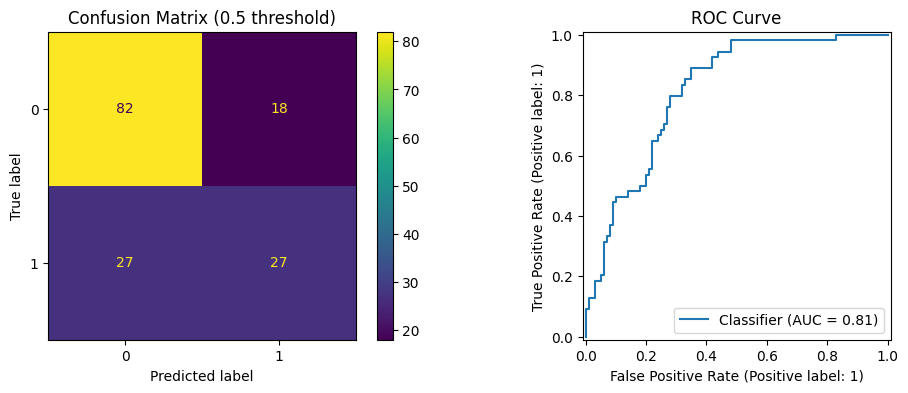

In [6]:
# STEP 3 — Minimal preprocessing + baseline Logistic Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# ---- 3.1 Treat impossible zeros as missing (classic for Pima dataset) ----
# These medical features shouldn't be zero in real life, so set 0 -> NaN, then impute.
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

X_train_fix = X_train.copy()
X_valid_fix = X_valid.copy()
for col in zero_as_missing:
    if col in X_train_fix.columns:
        X_train_fix.loc[X_train_fix[col] == 0, col] = np.nan
    if col in X_valid_fix.columns:
        X_valid_fix.loc[X_valid_fix[col] == 0, col] = np.nan

# ---- 3.2 Build baseline pipeline: Impute (median) -> Scale -> Logistic Regression ----
baseline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000))
])

# ---- 3.3 Fit & Predict ----
baseline.fit(X_train_fix, y_train)
proba_valid = baseline.predict_proba(X_valid_fix)[:, 1]
pred_valid  = (proba_valid >= 0.5).astype(int)

# ---- 3.4 Evaluate ----
acc = accuracy_score(y_valid, pred_valid)
auc = roc_auc_score(y_valid, proba_valid)
print(f"Baseline LogisticRegression — Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}\n")
print("Classification report:\n", classification_report(y_valid, pred_valid))

# ---- 3.5 Plots ----
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(y_valid, pred_valid, ax=ax[0])
ax[0].set_title("Confusion Matrix (0.5 threshold)")

RocCurveDisplay.from_predictions(y_valid, proba_valid, ax=ax[1])
ax[1].set_title("ROC Curve")
plt.show()

# Keep the trained model for next steps
baseline_model = baseline

RandomForest — Accuracy: 0.740 | ROC-AUC: 0.813

RF Classification report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154


Baseline LogisticRegression — Accuracy: 0.708 | ROC-AUC: 0.813

=== Validation Metrics ===
LogisticRegression -> ACC: 0.708 | AUC: 0.813
RandomForest       -> ACC: 0.740 | AUC: 0.813


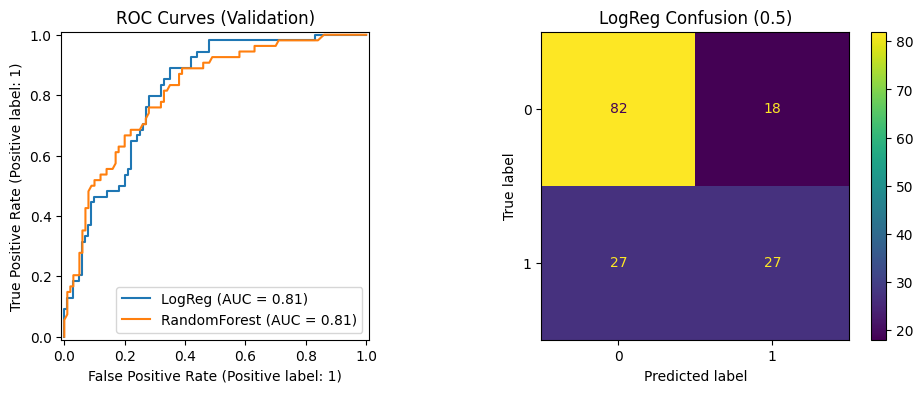

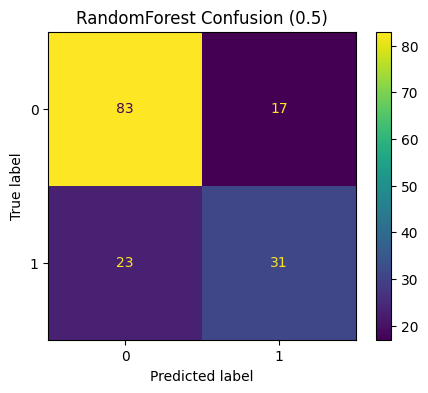

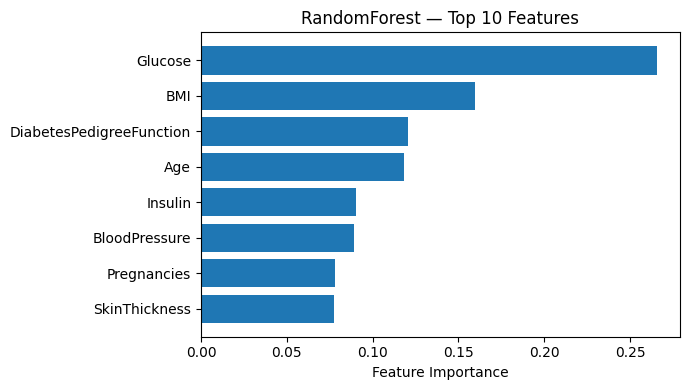


Best model selected for next step: RandomForest


In [7]:
# STEP 4 — Stronger model (RandomForest) + side-by-side comparison

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

# --- Reuse the zero→NaN fixed copies from Step 3 (X_train_fix / X_valid_fix) ---
# If you restarted the kernel, re-run Steps 2–3 first.

# 4.1 Fit Random Forest (robust on tabular data; handles non-linearities)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_fix, y_train)

# 4.2 Evaluate RF
rf_proba = rf.predict_proba(X_valid_fix)[:, 1]
rf_pred  = (rf_proba >= 0.5).astype(int)
rf_acc = accuracy_score(y_valid, rf_pred)
rf_auc = roc_auc_score(y_valid, rf_proba)

print(f"RandomForest — Accuracy: {rf_acc:.3f} | ROC-AUC: {rf_auc:.3f}")
print("\nRF Classification report:\n", classification_report(y_valid, rf_pred))

# 4.3 Evaluate baseline (from Step 3) again for side-by-side numbers
bl_proba = baseline_model.predict_proba(X_valid_fix)[:, 1]
bl_pred  = (bl_proba >= 0.5).astype(int)
bl_acc = accuracy_score(y_valid, bl_pred)
bl_auc = roc_auc_score(y_valid, bl_proba)

print("\nBaseline LogisticRegression — "
      f"Accuracy: {bl_acc:.3f} | ROC-AUC: {bl_auc:.3f}")

# 4.4 Simple comparison table
print("\n=== Validation Metrics ===")
print(f"LogisticRegression -> ACC: {bl_acc:.3f} | AUC: {bl_auc:.3f}")
print(f"RandomForest       -> ACC: {rf_acc:.3f} | AUC: {rf_auc:.3f}")

# 4.5 Plots: ROC curves and confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
RocCurveDisplay.from_predictions(y_valid, bl_proba, name="LogReg", ax=ax[0])
RocCurveDisplay.from_predictions(y_valid, rf_proba, name="RandomForest", ax=ax[0])
ax[0].set_title("ROC Curves (Validation)")
ax[0].legend(loc="lower right")

ConfusionMatrixDisplay.from_predictions(y_valid, bl_pred, ax=ax[1])
ax[1].set_title("LogReg Confusion (0.5)")
plt.show()

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_valid, rf_pred, ax=ax)
ax.set_title("RandomForest Confusion (0.5)")
plt.show()

# 4.6 Quick feature importance (top 10) — note: RF uses raw (pre-imputed/scaled) features
importances = rf.feature_importances_
feat_names = X_train_fix.columns
idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(7,4))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feat_names[i] for i in idx][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest — Top 10 Features")
plt.tight_layout()
plt.show()

# Keep best model reference for next step
best_model = rf if rf_auc >= bl_auc else baseline_model
print("\nBest model selected for next step:", "RandomForest" if best_model is rf else "LogisticRegression")

In [8]:
# STEP 5 — Threshold tuning (F1-optimal) + save a production-ready model

import os, joblib, numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

# ---------- 5.1: get proba on validation for the currently selected best_model ----------
# (best_model, baseline_model, rf, X_valid_fix, y_valid were defined in Steps 3–4)
proba_valid_best = best_model.predict_proba(X_valid_fix)[:, 1]

# Search thresholds and pick the one maximizing F1 on validation
prec, rec, thresh = precision_recall_curve(y_valid, proba_valid_best)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
# thresholds array has length len(prec)-1; align by ignoring the first prec/rec value
best_idx = np.nanargmax(f1s[1:])  # skip the first which corresponds to threshold=-inf
best_threshold = thresh[best_idx]

# Report metrics at 0.5 vs tuned threshold
pred_05   = (proba_valid_best >= 0.5).astype(int)
pred_tune = (proba_valid_best >= best_threshold).astype(int)

print("=== Validation metrics ===")
print(f"ROC-AUC (best model): {roc_auc_score(y_valid, proba_valid_best):.3f}")
print(f"F1 @0.50 : {f1_score(y_valid, pred_05):.3f}")
print(f"F1 @{best_threshold:.3f}: {f1_score(y_valid, pred_tune):.3f}")
print("\nClassification report @ tuned threshold:\n",
      classification_report(y_valid, pred_tune, digits=3))

# ---------- 5.2: Build a production pipeline and fit on ALL training data ----------
# Recreate the zero->NaN handling on the FULL dataset (train+valid)
X_all = X.copy()
y_all = y.copy()
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_as_missing:
    if col in X_all.columns:
        X_all.loc[X_all[col] == 0, col] = np.nan

# If the best model was the logistic baseline pipeline, clone & refit that pipeline on all data.
# If it was the RF, create a simple imputer+RF pipeline and fit on all data (robust to any NaNs).
if isinstance(best_model, Pipeline) and any(isinstance(s, LogisticRegression) for _, s in best_model.steps):
    prod_pipeline = clone(best_model)
    prod_pipeline.fit(X_all, y_all)
    prod_model_name = "LogisticRegression"
else:
    # Train RF inside a pipeline with imputation so it's safe in production
    prod_pipeline = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=400, random_state=42, n_jobs=-1
        ))
    ])
    prod_pipeline.fit(X_all, y_all)
    prod_model_name = "RandomForest"

# ---------- 5.3: Save the artifact (model + threshold + feature order) ----------
os.makedirs("./artifacts", exist_ok=True)
artifact = {
    "model": prod_pipeline,
    "threshold": float(best_threshold),
    "features": list(X_all.columns),
    "label_name": "Outcome",
    "model_name": prod_model_name
}
artifact_path = "./artifacts/pima_diabetes_best_model.joblib"
joblib.dump(artifact, artifact_path)
print(f"\n✅ Saved production artifact to: {artifact_path}")
print(f"   Includes: model='{prod_model_name}', tuned_threshold={best_threshold:.3f}, features={len(artifact['features'])}")

# ---------- 5.4: (Optional) quick smoke test: reload + predict on a few rows ----------
loaded = joblib.load(artifact_path)
proba_smoke = loaded["model"].predict_proba(X_all.head(5))[:, 1]
pred_smoke  = (proba_smoke >= loaded["threshold"]).astype(int)
print("\nReload smoke-test:")
print("proba:", np.round(proba_smoke, 3))
print("pred :", pred_smoke)

=== Validation metrics ===
ROC-AUC (best model): 0.813
F1 @0.50 : 0.608
F1 @0.245: 0.676

Classification report @ tuned threshold:
               precision    recall  f1-score   support

           0      0.909     0.600     0.723       100
           1      0.545     0.889     0.676        54

    accuracy                          0.701       154
   macro avg      0.727     0.744     0.699       154
weighted avg      0.782     0.701     0.706       154


✅ Saved production artifact to: ./artifacts/pima_diabetes_best_model.joblib
   Includes: model='RandomForest', tuned_threshold=0.245, features=8

Reload smoke-test:
proba: [0.87  0.035 0.842 0.002 0.895]
pred : [1 0 1 0 1]


In [10]:
# Inference demo — load artifact, predict on real data rows + one manual row

import os, joblib, pandas as pd, numpy as np

# 1) Load artifact
artifact_path = "./artifacts/pima_diabetes_best_model.joblib"
art = joblib.load(artifact_path)
pipe = art["model"]
thr  = art["threshold"]
cols = art["features"]
print(f"Loaded artifact: {artifact_path}\nModel: {art['model_name']}, threshold: {thr:.3f}")

# 2) Load a few real rows from the original CSV
csv_path = os.path.join("data", "pima_diabetes", "diabetes.csv")
df = pd.read_csv(csv_path)

# Ensure column order matches training
missing = [c for c in cols if c not in df.columns]
extra   = [c for c in df.columns if c not in cols + ["Outcome"]]
if missing:
    raise ValueError(f"Your CSV is missing columns expected by the model: {missing}")
X_real = df[cols].head(5)

# Predict on real rows
proba_real = pipe.predict_proba(X_real)[:, 1]
pred_real  = (proba_real >= thr).astype(int)
print("\nReal rows (first 5) — probabilities & predictions:")
for i, (p, yhat) in enumerate(zip(proba_real, pred_real), 1):
    print(f"Row{i}: proba={p:.3f}, pred={int(yhat)}")

# 3) One handcrafted example row (all required features present)
example = {c: 0 for c in cols}  # defaults; pipeline imputes as needed
example.update({
    "Pregnancies": 2,
    "Glucose": 140,
    "BloodPressure": 80,
    "SkinThickness": 25,
    "Insulin": 100,
    "BMI": 31.0,
    "DiabetesPedigreeFunction": 0.6,
    "Age": 50,
})
X_one = pd.DataFrame([example], columns=cols)

proba_one = pipe.predict_proba(X_one)[:, 1][0]
pred_one  = int(proba_one >= thr)
print("\nManual row — proba & pred:")
print(f"proba={proba_one:.3f}, pred={pred_one}")

Loaded artifact: ./artifacts/pima_diabetes_best_model.joblib
Model: RandomForest, threshold: 0.245

Real rows (first 5) — probabilities & predictions:
Row1: proba=0.530, pred=1
Row2: proba=0.045, pred=0
Row3: proba=0.590, pred=1
Row4: proba=0.003, pred=0
Row5: proba=0.895, pred=1

Manual row — proba & pred:
proba=0.537, pred=1
